# DCGAN for Gray female
**Author** - [Vuong NGUYEN](https://github.com/XuanMinhVuongNGUYEN)

This tutorial introduces you to the basics of the [Augmentare](https://forge.deel.ai/Fair/augmentare) library to easily use the deployment of Machine Learning techniques to augment data in **PyTorch**. This tutorial mainly explores the core features of library, the predefined losses and the models. 

This tutorial assumes that your system has installed **Pytorch** and **Augmentare** properly.

This tutorial uses the highly popular Deep Convolutional GAN or **DCGAN** architecture. **Augmentare** provides a generalised implementation of **DCGAN**.

**Paper** - [Unsupervised Representation Learning With Deep Convolutional Generative Aversarial Networks by Radford & al.](https://arxiv.org/abs/1511.06434)

In [1]:
try:
    import augmentare
    print(f"Existing Augmentare {augmentare.__version__} installation found")

except ImportError:
    import subprocess
    import sys

    subprocess.check_call([sys.executable, "-m", "pip", "install", "augmentare"])
    import augmentare

    print(f"Installed Augmentare {augmentare.__version__}")

/home/vuong.nguyen/vuong/augmentare/dev_augmentare/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/vuong.nguyen/vuong/augmentare/dev_augmentare/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/vuong.nguyen/vuong/augmentare/dev_augmentare/lib/python3.9/site-packages/torchvision/image.so: undefined symbol: _ZN3c104impl8GPUTrace13gpuTraceStateE'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


Existing Augmentare 0.0.1 installation found


## IMPORTS

In [2]:
# General Imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import ImageFile
from PIL import Image
ImageFile.LOAD_TRUNCATED_IMAGES = True

# Pytorch and Torchvision Imports
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.utils.data as data
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torchvision.utils as vutils

# Augmentare Imports
import augmentare
from augmentare.methods.gan import *
from augmentare.plots.plot_losses import plot_losses_gan
from augmentare.plots.plot_samples import plot_image

In [3]:
#Cuda
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


## DATA LOADING AND PREPROCESSING

In [4]:
train_df = pd.read_csv('dataframe_dataset/df_female_gray.csv')

In [5]:
image_path = "/home/vuong.nguyen/vuong/augmentare/Bias Celeba/dataset/img_align_celeba/img_align_celeba"

In [6]:
class CelebDataset(Dataset):
    def __init__(self, df, image_path, transform=None, mode='train'):
        super().__init__()
        self.sen = df['Sens']
        self.label = df['Male']
        self.path = image_path
        self.image_id = df['image_id']
        self.transform=transform
        self.mode=mode

    def __len__(self):
        return self.image_id.shape[0]

    def __getitem__(self, idx:int):
        image_name = self.image_id.iloc[idx]
        image = Image.open(os.path.join(image_path, image_name))
        labels = np.asarray(self.label.iloc[idx].T)
        sens = np.asarray(self.sen.iloc[idx].T)

        if self.transform:
            image=self.transform(image)
        return image, labels

In [7]:
image_size = 64

transform = transforms.Compose([
    transforms.Resize((image_size,image_size)),
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(0.5),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
    ])  

dataset=CelebDataset(train_df,image_path,transform)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True, num_workers=4, pin_memory=True)

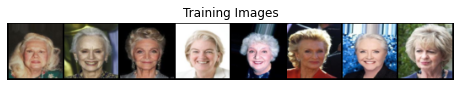

In [8]:
#Plot some training images 
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

## NETWORK ARCHITECTURE : DCGAN

### GENERATOR NETWORK
The DCGAN Generator receives an input noise vector of size $batch\ size \times latent\ size$. It outputs a tensor of $batch\ size \times channel \times height \times width$ corresponding to a batch of generated image samples. The generator transforms the noise vector into images in the following manner:

1. **Channel Dimension**: $encoding\ dims \rightarrow d \rightarrow \frac{d}{2} \rightarrow \frac{d}{4} \rightarrow \frac{d}{8} \rightarrow 1$.
2. **Image size**: $(1 \times 1) \rightarrow (4 \times 4) \rightarrow (8 \times 8) \rightarrow (16 \times 16) \rightarrow (32 \times 32) \rightarrow (64 \times 64)$. 

The intermediate layers use the **ReLU** activation function to kill gradients and slow down convergence. We can also use any other activation to ensure a good gradation flow. The last layer uses the **Tanh** activation to constrain the pixel values ​​to the range of $(- 1 \to 1)$. We can easily change the nonlinearity of the intermediate and last layers to their preferences by passing them as parameters during Generator object initialization. 

### DISCRIMINATOR NETWORK
The DCGAN Discriminator has a symmetric architecture to the generator. It maps the image with a confidence score to classify whether the image is real (i.e. comes from the dataset) or fake (i.e. sampled by the generator) 

We use the **Leaky ReLU** activation for Discriminator. The conversion of image tension to confidence score is as follows: 

1. **Channel Dimension**: $1 \rightarrow d \rightarrow 2 \times d \rightarrow 4 \times d \rightarrow 8 \times d \rightarrow 1$.
2. **Image size**: $(64 \times 64) \rightarrow (32 \times 32) \rightarrow (16 \times 16) \rightarrow (8 \times 8) \rightarrow (4 \times 4) \rightarrow (1 \times 1)$.

The last layer of DCGAN's Discriminator has a **Sigmoid** layer that makes the confidence score between $(0 \to 1)$ and allows the confidence score to be easily interpreted in terms of the probability that the image is real. However, this interpretation is restricted only to the Minimax Loss proposed in the original GAN paper, and losses such as the Wasserstein Loss require no such interpretation. However, if required, one can easily set last layer activation to **Sigmoid** by passing it as a parameter during initialization time.

#### DCGAN Generator

A generator for mapping a latent space to a sample space.

Hyperparameters:

`num_channels:` Number of channels in the training images

`latent_size:` Size of latent vector (i.e. size of generator input)

`feature_map_size:` Size of feature maps in generator

In [9]:
net_gen = DCGANGenerator(
    num_channels=3,
    latent_size=128,
    feature_map_size=64
)

#### DCGAN Discriminator

A discriminator for discerning real from generated images.
Output activation is Sigmoid.

Hyperparameters:

`num_channels:` Number of channels in the training images

`feature_map_size:` Size of feature maps in discriminator

In [10]:
net_dis = DCGANDiscriminator(
    num_channels=3,
    feature_map_size=64
)

## OPTIMIZERS AND LOSS FUNCTIONS

This tutorial for the example about **DCGAN** optimized by the Adam optimizer and used a function loss is **BCELoss**.

#### Other Parameters (optimizer, loss function)

**Adam** optimizer is often used to train neural networks, it usually avoids the need for hyperparameter search on parameters like learning rate, etc. **Adam** has hyperparameters that usually don't require much tuning:

-`Learning rate:` or step size. The weightes are updated (e.g. 0.001). A larger value (e.g. 0.3) results in faster initial learning before the rate is updated. Smaller values ​​(eg: 1.0e-5) slow down the learning right during training. Here we set $lr=0.0002$

-`Beta1:` Exponential decay rate for the first time estimate. Here we set $0.5$

-`Beta2:` Exponentially decay rate for second time estimates. This value should be set close to $1.0$ for problems with sparse gradients (e.g. NLP and computer vision problems). Hence we set $0.999$ 

We use this **BCELoss** function in the case where the final output from the network is a single value (the last dense layer of size 1) is between 0 and 1. 


In [11]:
optimizer_gen = Adam(net_gen.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_dis = Adam(net_dis.parameters(), lr=0.0002, betas=(0.5, 0.999))
loss_fn_gen =  nn.BCELoss()
loss_fn_dis =  nn.BCELoss()

#### Create your GAN object

A basic DCGAN class for generating images.

Parameters:

`generator:` A torch DCGAN Generator architecture

`discriminator:` A torch DCGAN Discriminator architecture

`optimizer_gen:` An optimizer for generator

`optimizer_dis:` An optimizer for discriminator

`loss_fn_gen:` A loss function for generator

`loss_fn_dis:` A loss function for discriminator

`device:` Cpu or CUDA

`latent_size:` Size of latent vector (i.e size of generator input)

In [12]:
# Create GAN network
gan = DCGAN(
    net_gen,
    net_dis,
    optimizer_gen,
    optimizer_dis,
    loss_fn_gen,
    loss_fn_dis,
    device,
    latent_size=128,
    init_weights=True
)

## TRAINING THE DCGAN NETWORK

Training the model is quite expensive. Hence, we will train models for 10 epochs if GPU is available, otherwise we will train only for 5 epochs. We should change **num_epochs** so that the model learns to generate good quality images.

Train both generator and discriminator and return the losses.

Parameters:

`subset_a:` Torch.tensor or Dataset

`num_epochs:` The number of epochs you want to train your GAN

`num_decay_epochs:` The number of epochs to start linearly decaying the learning rate to 0 (optional)

`num_classes:` Number of classes in dataset (optional)

`batch_size:` Training batch size (optional)

`subset_b:` The second Torch.tensor or Dataset (optional)

Returns:

`gen_losses, dis_losses:` The losses of both the discriminator and generator

In [13]:
gen_losses, dis_losses = gan.train(
    subset_a=dataloader,
    num_epochs=200,
    num_decay_epochs = None,
    num_classes = None,
    batch_size = None,
    subset_b = None 
)

[1/200][0/112]                             	Loss_D: 3.106093406677246 	Loss_G: 0.8306063413619995
[1/200][50/112]                             	Loss_D: 0.019504990428686142 	Loss_G: 12.528005599975586
[1/200][100/112]                             	Loss_D: 0.005691329948604107 	Loss_G: 14.79172420501709
[2/200][0/112]                             	Loss_D: 0.020585164427757263 	Loss_G: 21.423917770385742
[2/200][50/112]                             	Loss_D: 2.3843324015615508e-05 	Loss_G: 37.125274658203125
[2/200][100/112]                             	Loss_D: 3.5849712730851024e-05 	Loss_G: 33.22108840942383
[3/200][0/112]                             	Loss_D: 0.0002500290283933282 	Loss_G: 26.51317596435547
[3/200][50/112]                             	Loss_D: 4.721468212665059e-05 	Loss_G: 38.40967559814453
[3/200][100/112]                             	Loss_D: 0.0022628135047852993 	Loss_G: 38.6430778503418
[4/200][0/112]                             	Loss_D: 7.748614052616176e-07 	Loss_G: 3

#### Plots the Losses

Plots losses for generator and discriminator on a common plot.

Parameters:

`gen_losses:` A list of generator losses
    
`dis_losses:` A list of discriminator losses

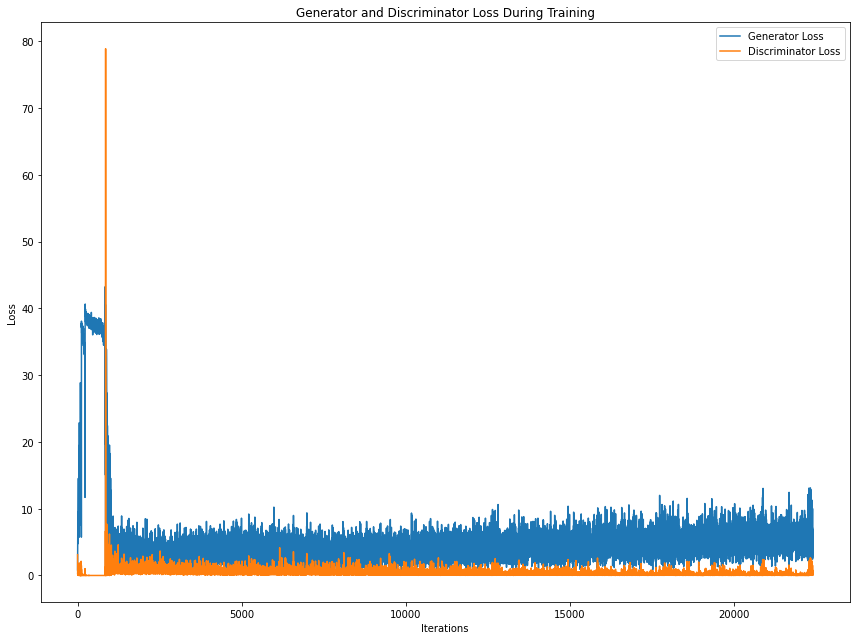

In [14]:
plot_losses_gan(gen_losses, dis_losses)

## VISUALIZE THE GENERATED DATA



#### Sample images from the generator.

Parameters:

`nb_samples:` The number of samples to generate

`num_classes:` Number of classes in dataset (optional)

`real_image_a:` Real image in subset_a (optional)

`real_image_b:` Real image in subset_b (optional)

Returns:

`img_list:` A list of generated images

In [15]:
torch.save(gan, f"/home/vuong.nguyen/vuong/augmentare/Bias Celeba/Weights_GAN/dcgan_female_gray.pth")
torch.cuda.empty_cache()

In [16]:
img_list, fake_data = gan.generate_samples(
    nb_samples=64,
    num_classes = None,
    real_image_a = None,
    real_image_b = None
)

#### Plots images

Plot a number of generated images with optional label

Parameters:

`img_list:` A list of generated images (Torch tensor)

`number:` Number of images we want to plot

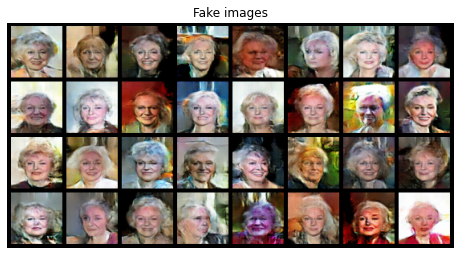

In [17]:
plot_image(img_list, number=32)